# Movie Pairing Recommender System

## Imports

In [1]:
!which python3

/home/secouss/repos/recommender_system_project/.venv/bin/python3


In [2]:
import os
from typing import List, Dict

import numpy as np
import pandas as pd
import scipy.sparse
import sklearn.cluster
import sklearn.feature_extraction.text
import sklearn.model_selection
import sklearn.metrics
from tqdm import tqdm

## 1. Data Collection and Preprocessing

### Load the MovieLens datasets

In [3]:
DIR_DATA = "./data/ml-latest-small/"

In [4]:
movies = pd.read_csv(os.path.join(DIR_DATA, "movies.csv"))
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [5]:
ratings = pd.read_csv(os.path.join(DIR_DATA, "ratings.csv"))
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


### Stats

In [8]:
ratings["rating"].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

## 2. Feature Engineering

### Extract relevant features (try genres, directors, cast, and ratings)

### Create a user-item interaction matrix for collaborative filtering

In [27]:
def get_fav_movies_of_user(ratings : pd.DataFrame, user_id : int, n : int) -> List[int]:
    """Get the n favorites movies of an user according the ratings"""
    return ratings[ratings["userId"] == user_id].sort_values(by="rating", ascending=False).iloc[:n,:]["movieId"].values

def get_users(df : pd.DataFrame) -> List[int]:
    """Get all the users"""
    return df["userId"].sort_values().unique()

# create a mapping beetween movie id and their index in the interaction matrix 
movie_id_to_index = {movie_id : index for index, movie_id in enumerate(ratings["movieId"].unique())}

get_fav_movies_of_user(ratings, 1, 10)

array([2949, 3703, 3729, 3793,  151,  157,  163,  216,  231,  260])

In [73]:
def create_user_item_interaction_matrix_with_only_ratings_only(ratings : pd.DataFrame, movie_id_to_index : Dict[int, int], verbose : bool=False, n : int =100):
    """Create a user-item interaction matrix for collaborative filtering.
    Only the ratings are used as features.
    The n favorites movies represent 1 and other values are 0.

    Returns:
        A sparse matrix. 1 if a movie is part of the favorites movies of the user, 0 otherwise.
    """

    # get all the users
    users = get_users(ratings)
    
    # get the favorites move of each user
    fav_movies = [
        get_fav_movies_of_user(ratings, user_id, n)
        for user_id in tqdm(users, total=users.shape[0], disable=not verbose)
    ]
    
    X = np.zeros((len(fav_movies), len(movie_id_to_index)))
    for index, fav_movies in enumerate(fav_movies):
        for movie_id in fav_movies:
            X[index, movie_id_to_index[movie_id]] = 1

    return scipy.sparse.csr_matrix(X)

X = create_user_item_interaction_matrix_with_only_ratings_only(ratings, movie_id_to_index, verbose=True)
X.shape

100%|██████████| 610/610 [00:00<00:00, 2465.67it/s]


(610, 9724)

## 3. Model Development (predict the rating of a movie by a couple of users)

### Kmeans

100%|██████████| 19/19 [00:00<00:00, 37.73it/s]


<Axes: xlabel='k_values'>

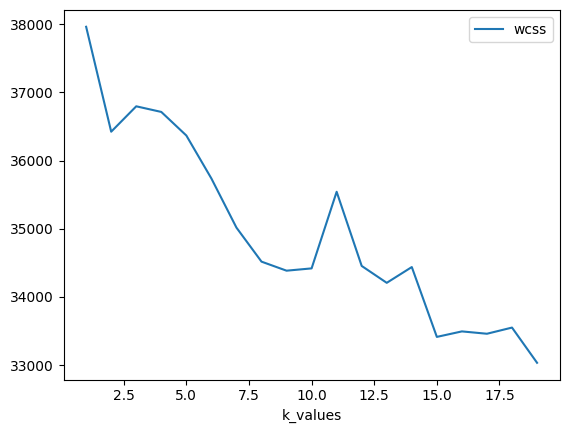

In [29]:
# we are searching a good k for the dataset

k_values = list(range(1, 20))
wcss = [
    sklearn.cluster.KMeans(n_clusters=k).fit(X).inertia_
    for k in tqdm(k_values)
]

pd.DataFrame({"wcss" : wcss, "k_values": k_values}).plot.line(x="k_values", y="wcss")

15 seems to be a good number of clusters

In [30]:
kmeans = sklearn.cluster.KMeans(n_clusters=15).fit(X)

In [31]:
def create_model() -> sklearn.cluster.KMeans:
    return sklearn.cluster.KMeans(n_clusters=15, init="k-means++") 

def train_model(kmeans, X) -> None:
    kmeans.fit(X.astype(np.int32))

def compute_clusters(kmeans, X) -> pd.DataFrame:
    """Compute the clusters of each user

    Args:
        kmeans: Kmeans model
        X: user-item interaction matrix
    """
    clusters = kmeans.predict(X)
    return pd.DataFrame({"userId": get_users(ratings), "cluster" : clusters})

kmeans = create_model()
train_model(kmeans, X)

clusters = compute_clusters(kmeans, X)
clusters.groupby(by="cluster").count().rename(columns={"userId": "count"}).T

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,1,66,95,2,1,90,9,37,54,63,188,1,1,1,1


In [32]:
def compute_clusters_ratings(clusters : pd.DataFrame, ratings : pd.DataFrame) -> pd.DataFrame:
    """Compute ratings of each clusters by computing the mean of the user's ratings for each clusters"""

    return pd.merge(left=clusters, right=ratings, on="userId", validate="1:m").groupby(by=["cluster", "movieId"]).agg({"rating": "mean"}).reset_index()

clusters_ratings = compute_clusters_ratings(clusters, ratings)
clusters_ratings

,cluster,movieId,rating
0,0,1,3.0
1,0,10,4.5
2,0,50,4.5
3,0,62,3.0
4,0,110,4.0
...,...,...,...
28278,14,130576,2.0
28279,14,135133,4.0
28280,14,164909,2.5
28281,14,165549,1.5


In [33]:
def compute_cluster_group_of_user(
    ratings: pd.DataFrame, kmeans: sklearn.cluster.KMeans, users_id: List[int], verbose : bool =False
) -> int:
    """Compute the cluster of a group of user with the kmeans model and their ratings.
    The group of user is represented as one user by merging their ratings.

    Returns:
        int: The user's cluster
    """

    # merge their ratings
    users_ratings = ratings[ratings["userId"].isin(users_id)].copy()

    # new user id to reprensent the couple (or more people) as a user
    users_ratings["userId"] = 0

    # create user item interation matrix
    X = create_user_item_interaction_matrix_with_only_ratings_only(
        users_ratings, movie_id_to_index, verbose=verbose
    )

    # predict the cluster of this couple
    cluster = kmeans.predict(X)[0]

    return cluster

def get_default_rating_prediction(ratings : pd.DataFrame, movie_id : int) -> float:
    """Get the average rating of a movie"""
    return ratings[ratings["movieId"] == movie_id].mean()

def predict_rating(
    ratings: pd.DataFrame,
    kmeans: sklearn.cluster.KMeans,
    clusters_ratings: pd.DataFrame,
    movie_id: int,
    users_id: List[int],
    verbose: bool = False,
) -> float:
    """Predict the rating of a movie by a couple of users (at least one user and more if wanted).

    Returns:
        float: The rating of the movie
    """

    log = print if verbose else lambda _: None

    cluster = compute_cluster_group_of_user(ratings, kmeans, users_id)
    log(f"Cluster's users is : {cluster}")

    # get the cluster ratings
    cluster_ratings = clusters_ratings[clusters_ratings["cluster"] == cluster]

    # get the rate of the movie given
    movie_ratings = cluster_ratings[cluster_ratings["movieId"] == movie_id]
    if movie_ratings.shape[0] > 0:
        # should have only one rating
        rate = movie_ratings.iloc[0, :]["rating"]
    else:
        log("The movie has not been rated by the cluster")
        log(cluster_ratings["movieId"].sort_values().unique())
        log(cluster_ratings[cluster_ratings["movieId"] == movie_id])
        rate = get_default_rating_prediction(ratings, movie_id)

    return rate

predict_rating(ratings, kmeans, clusters_ratings, 5, [1, 2], verbose=True)

Cluster's users is : 9


2.4

In [34]:
def get_default_ratings_prediction(ratings : pd.DataFrame) -> pd.DataFrame:
    """Same as 'get_default_rating_prediction' but for every movie.
    Used when a movie has not been rated by a user or a cluster. 

    Returns:
        pd.DataFrame: The average rating of each movie.
    """
    return ratings.groupby(by="movieId").agg({"rating": "mean"}).reset_index()

default_predictions = get_default_ratings_prediction(ratings)
default_predictions

,movieId,rating
0,1,3.920930
1,2,3.431818
2,3,3.259615
3,4,2.357143
4,5,3.071429
...,...,...
9719,193581,4.000000
9720,193583,3.500000
9721,193585,3.500000
9722,193587,3.500000


In [59]:
def predict_all_ratings(
    ratings: pd.DataFrame,
    kmeans: sklearn.cluster.KMeans,
    clusters_ratings: pd.DataFrame,
    users_id: List[int],
    default_predictions : pd.DataFrame
) -> pd.DataFrame:
    """Similar as 'predict_rating' but predict for all movies for optimizing purposes. 

    Returns:
        pd.DataFrame: The movies associated with their predictions (from 0 to 5)
    """

    cluster = compute_cluster_group_of_user(ratings, kmeans, users_id)
    cluster_ratings = clusters_ratings[clusters_ratings["cluster"] == cluster]

    # users of the cluster do not always have rated all the movies,
    # we need to fill values with default one
    lacking_predictions = default_predictions[~default_predictions["movieId"].isin(cluster_ratings["movieId"])]

    return pd.concat([cluster_ratings[["movieId", "rating"]], lacking_predictions])

predict_all_ratings(ratings, kmeans, clusters_ratings, [1, 2], default_predictions)

,movieId,rating
19228,1,4.000000
19229,2,3.075000
19230,3,3.045455
19231,5,2.400000
19232,6,3.958333
...,...,...
9719,193581,4.000000
9720,193583,3.500000
9721,193585,3.500000
9722,193587,3.500000


## 4. Recommendation Algorithm

In [60]:
def suggest_movies(ratings : pd.DataFrame, kmeans, users_id : List[int], n : int) -> pd.DataFrame:
    """Suggest one movie that might be liked by the couple of users

    Returns:
        pd.DataFrame: The list of suggested movies  
    """

    cluster = compute_cluster_group_of_user(ratings, kmeans, users_id)

    # get the cluster ratings
    cluster_ratings = clusters_ratings[clusters_ratings["cluster"] == cluster]

    suggestions = cluster_ratings.sort_values(by="rating", ascending=False).iloc[:n,:][["movieId", "rating"]]
    suggestions = movies[movies["movieId"].isin(suggestions["movieId"])]

    return suggestions

suggest_movies(ratings, kmeans, [1, 2], 5)

,movieId,title,genres
1051,1366,"Crucible, The (1996)",Drama
1247,1658,"Life Less Ordinary, A (1997)",Romance|Thriller
2279,3022,"General, The (1926)",Comedy|War
4604,6857,Ninja Scroll (Jûbei ninpûchô) (1995),Action|Adventure|Animation|Fantasy
8839,132333,Seve (2014),Documentary|Drama


## 5. Evaluation

### Split dataset

In [61]:
r_train, r_test = sklearn.model_selection.train_test_split(ratings, test_size=0.2)

### Regroup functions into a class

In [84]:
class My_Kmeans_Recommender:

    def __init__(self, movie_id_to_index : Dict[int, int]):
        clusters.groupby(by="cluster").count().rename(columns={"userId": "count"}).T
        
        self.movie_id_to_index = movie_id_to_index
        self.kmeans = create_model()

    def train(self, r_train : pd.DataFrame) -> None:

        self.ratings = r_train
        self.X_train = create_user_item_interaction_matrix_with_only_ratings_only(self.ratings, self.movie_id_to_index, n=100)
        train_model(self.kmeans, self.X_train)

        self.clusters_ratings_train = compute_clusters_ratings(compute_clusters(self.kmeans, self.X_train), self.ratings)
        self.default_predictions = get_default_ratings_prediction(self.ratings)

    def predict(self, movieId_and_userId : pd.DataFrame) -> pd.DataFrame:

        users = get_users(movieId_and_userId)

        # self.default_predictions has been computed with only train dataset,
        # the default ratings lack ratings on movies that are only in the test dataset,
        # fill by the average rating of all the movie for all the user 
        all_movies_without_default_predictions = movieId_and_userId[~movieId_and_userId["movieId"].isin(self.default_predictions["movieId"])]["movieId"].unique()
        other_default_ratings = pd.DataFrame({"movieId" : all_movies_without_default_predictions, "rating": self.ratings["rating"].mean()})
        default_predictions = pd.concat([self.default_predictions, other_default_ratings])

        # predict the ratings for all the users in the test dataset  
        predictions = []
        for user_id in tqdm(users, desc="Compute all predictions"):
            predictions_of_one_user = predict_all_ratings(self.ratings, self.kmeans, self.clusters_ratings_train, users_id=[user_id], default_predictions=default_predictions)
            predictions_of_one_user["userId"] = user_id

            predictions.append(predictions_of_one_user)
        
        predictions = pd.concat(predictions)

        # rename 'rating' by 'rating_pred' to avoid confusion
        predictions.rename(columns={"rating": "rating_pred"}, inplace=True)

        # filter all the predictions by those asked
        predictions_merged = pd.merge(left=movieId_and_userId, right=predictions, on=["movieId", "userId"], how="inner", validate="1:1")
        assert predictions_merged.shape[0] == movieId_and_userId.shape[0]

        return predictions_merged

### Evaluate

In [85]:
model = My_Kmeans_Recommender(movie_id_to_index)
model.train(r_train)
predictions = model.predict(r_test[["movieId", "userId"]])
predictions

Compute all predictions: 100%|██████████| 609/609 [00:02<00:00, 250.49it/s]


,movieId,userId,rating_pred
0,1721,116,2.972222
1,3147,325,4.068627
2,2353,249,3.625000
3,6862,448,3.500000
4,290,437,3.722222
...,...,...,...
20163,271,411,4.000000
20164,2686,383,4.000000
20165,2490,586,2.333333
20166,1888,19,3.000000


In [86]:
def evaluate(y_true, y_pred):
    r2_score = sklearn.metrics.r2_score(y_true, y_pred)
    mean_square = sklearn.metrics.mean_squared_error(y_true, y_pred)
    print(f"mean_square = {mean_square:0.3f}, r2_score = {r2_score:0.3f}")

evaluate(y_true=r_test["rating"], y_pred=predictions["rating_pred"])

mean_square = 1.023, r2_score = 0.066


The r2 score is too close from 0 meaning that our model is not way better that a dummy recommender...

### Evaluate dummy recommender

In [77]:
all_mean_predictions = [r_train["rating"].mean()] * r_test.shape[0]
evaluate(y_true=r_test["rating"], y_pred=all_mean_predictions)

mean_square = 1.096, r2_score = -0.000
